# DS-7331 Machine Learning Project 2
## Airbnb Price Data - Classification and Regression
### Allen Miller, Ana Glaser, Jake Harrison, Lola Awodipe

In [1]:
#loading libraries
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
from scipy import stats


from sklearn import metrics as mt

### Table of Contents
0. Background
1. Data Preparation
    <br>
    1.1 Data Preperation before task split 
    <br>
    1.2 Data Preparation for Classification Models
    <br>
    1.3 Data Preparation for Regression Models
    <br>
2. Modeling and Evaluation
    <br>
    2.1 Evaluation Metrics
    <br>
    2.2 Method for Splitting train and test data
    <br>
        2.2.1 Classification
        <br>
        2.2.2 Regression

#### Background
We are using Airbnb data provided by Kaggle to estimate the price of Airbnb properties, as well as classifying the property type. In this project, we will perform two tasks: regression and classification.

For the regression, we will be using models such as Lasso Regression and Random Forest Regression to predict the price of a listing.

For the classification, we will be using the Logistic Regression, KNN, and Random Forest to predict the property type of the listing.

In [2]:
#setting path and loading data
pdata = pd.read_csv("airbnb.csv")

### 1. Data Preparation

#### 1.1 Data Preparation before classification / regression data split

In [3]:
#Define Class variables
pdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74111 entries, 0 to 74110
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      74111 non-null  int64  
 1   log_price               74111 non-null  float64
 2   property_type           74111 non-null  object 
 3   room_type               74111 non-null  object 
 4   accommodates            74111 non-null  int64  
 5   bathrooms               73911 non-null  float64
 6   bed_type                74111 non-null  object 
 7   cancellation_policy     74111 non-null  object 
 8   cleaning_fee            74111 non-null  bool   
 9   city                    74111 non-null  object 
 10  description             74111 non-null  object 
 11  first_review            58247 non-null  object 
 12  host_has_profile_pic    73923 non-null  object 
 13  host_identity_verified  73923 non-null  object 
 14  host_response_rate      55812 non-null

In [4]:
#Evaluating skewness
pdata.skew()
#Decided to make a cutoff for number_of_reviews, review_scores_rating, and beds because of outliers and non-normal data

id                     -0.260616
log_price               0.514695
accommodates            2.231561
bathrooms               3.691453
cleaning_fee           -1.059603
latitude               -0.534766
longitude              -0.407100
number_of_reviews       3.702835
review_scores_rating   -3.380861
bedrooms                1.989849
beds                    3.358000
dtype: float64

In [5]:
#removing outliers to reduce skewness of data 
z = pdata[pdata['number_of_reviews']> 100]
for i in list (z[z['number_of_reviews']> 100].index):
    pdata.loc[i,'number_of_reviews'] = 100
    
y = pdata[pdata['review_scores_rating']< 80]
for i in list (y[y['review_scores_rating']< 80].index):
    pdata.loc[i,'review_scores_rating'] = 80
    
x = pdata[pdata['beds']> 5]
for i in list (x[x['beds']> 5].index):
    pdata.loc[i,'beds'] = 5

In [6]:
#evaluating data for skewness after outlier transformation
pdata.skew()

id                     -0.260616
log_price               0.514695
accommodates            2.231561
bathrooms               3.691453
cleaning_fee           -1.059603
latitude               -0.534766
longitude              -0.407100
number_of_reviews       1.841134
review_scores_rating   -1.143345
bedrooms                1.989849
beds                    1.692681
dtype: float64

#### 1.2 Data Preparation for Classification Task

In [7]:
#dropping records with excess blank values, still had over 64k records to evaluate
pdata_cls = pdata.dropna()

In [8]:
#evaluating data for skewness after outlier transformation after splitting data based on task
pdata_cls.skew()

id                     -0.255823
log_price               0.377120
accommodates            2.119839
bathrooms               3.705744
cleaning_fee           -1.701312
latitude               -0.649299
longitude              -0.502707
number_of_reviews       1.268297
review_scores_rating   -1.155152
bedrooms                1.874469
beds                    1.539853
dtype: float64

To assist in predicting the property type of an Airbnb we decided to make a couple of changes to the features that could increase the predictability. 

We first collapsed the property type feature to only contain two distinct values, making this a binary classification problem. A property type could only be classified as Apartment or Other. This eliminated the smaller sub-types of a property such as, Loft, Condo, House, etc. We chose Apartment due to the large amounts of observations that were present in the data set and saw an increase in our accuracy (found at the end of this report)

Second we decided to remove the longitude and latitude variables and replace them with a variable called region. This variable split the United States in half and classified the observation as either East or West. This increased the performance of our models and allowed us to reduce the number of predictors included in the models.

In [9]:
#transforming the property type to a binary classification
value_list = ["Apartment"]
boolean_series = ~pdata_cls.property_type.isin(value_list)
filtered_df = pdata_cls[boolean_series]

filtered_df.head(100)

for i in list (filtered_df.index):
    pdata_cls.loc[i,'property_type'] = "other"

#transforming the longitude and latitude variables to East / West
pdata_cls["region"] = pd.cut(pdata_cls.longitude,[-200,-100,0],2,labels=["West","East"])

In [10]:
#evaluating the data after transformation
pdata_cls.head()

,id,log_price,property_type,room_type,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,...,last_review,latitude,longitude,neighbourhood,number_of_reviews,review_scores_rating,zipcode,bedrooms,beds,region
1,6304928,5.129899,Apartment,Entire home/apt,7,1.0,Real Bed,strict,True,NYC,...,9/23/2017,40.766115,-73.989040,Hell's Kitchen,6,93.0,10019,3.0,3.0,East
2,7919400,4.976734,Apartment,Entire home/apt,5,1.0,Real Bed,moderate,True,NYC,...,9/14/2017,40.808110,-73.943756,Harlem,10,92.0,10027,1.0,3.0,East
4,3808709,4.744932,Apartment,Entire home/apt,2,1.0,Real Bed,moderate,True,DC,...,1/22/2017,38.925627,-77.034596,Columbia Heights,4,80.0,20009,0.0,1.0,East
5,12422935,4.442651,Apartment,Private room,2,1.0,Real Bed,strict,True,SF,...,9/5/2017,37.753164,-122.429526,Noe Valley,3,100.0,94131,1.0,1.0,West
7,13971273,4.787492,other,Entire home/apt,2,1.0,Real Bed,moderate,True,LA,...,4/12/2017,34.046737,-118.260439,Downtown,9,93.0,90015,1.0,1.0,West


To help our model we encoded all of the boolean features that were originally stored as character fields to reflect actual boolean type variables and reflected true values with a 1 and false values with a 0.

We also encoded our response variable to 1 vs 2 to reflect Apartment vs Other.

In [11]:
#Encoding boolean and categorical variables
replaceStruct = {
                "cleaning_fee":     {True: 1, False: 0},
                "instant_bookable":     {"t": 1, "f": 0},
                "host_identity_verified":     {"t": 1, "f": 0},
                "property_type":     {"Apartment": 1, "other": 2},
                    }

pdata_cls=pdata_cls.replace(replaceStruct)
pdata_cls.head()

,id,log_price,property_type,room_type,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,...,last_review,latitude,longitude,neighbourhood,number_of_reviews,review_scores_rating,zipcode,bedrooms,beds,region
1,6304928,5.129899,1,Entire home/apt,7,1.0,Real Bed,strict,1,NYC,...,9/23/2017,40.766115,-73.989040,Hell's Kitchen,6,93.0,10019,3.0,3.0,East
2,7919400,4.976734,1,Entire home/apt,5,1.0,Real Bed,moderate,1,NYC,...,9/14/2017,40.808110,-73.943756,Harlem,10,92.0,10027,1.0,3.0,East
4,3808709,4.744932,1,Entire home/apt,2,1.0,Real Bed,moderate,1,DC,...,1/22/2017,38.925627,-77.034596,Columbia Heights,4,80.0,20009,0.0,1.0,East
5,12422935,4.442651,1,Private room,2,1.0,Real Bed,strict,1,SF,...,9/5/2017,37.753164,-122.429526,Noe Valley,3,100.0,94131,1.0,1.0,West
7,13971273,4.787492,2,Entire home/apt,2,1.0,Real Bed,moderate,1,LA,...,4/12/2017,34.046737,-118.260439,Downtown,9,93.0,90015,1.0,1.0,West


We proceeded to one hot encode the categorical variables that we were going to leave in our models. This created a reference variable (0) and allows us to interpret the coefficients of the variables easier.

We also evaluated the number of unique values found in the categorical variables, since hot-encoding the neighborhood attribute, which seemed useful in predicting property type in some cases, had 590 distinct values.  This made the model run time very slow and only gained a modest amount of accuracy.

We then dropped all of the other columns that would not be used in the proceeding models, like property descriptions, and those that resulted in a 0.0 coefficient value, lacking predictive power.

In [12]:
#evaluating categorical value count for one-hot-encoding
pdata_cls.nunique()

id                        42775
log_price                   643
property_type                 2
room_type                     3
accommodates                 16
bathrooms                    17
bed_type                      5
cancellation_policy           5
cleaning_fee                  2
city                          6
description               42424
first_review               2489
host_has_profile_pic          2
host_identity_verified        2
host_response_rate           77
host_since                 3000
instant_bookable              2
last_review                1100
latitude                  42758
longitude                 42734
neighbourhood               590
number_of_reviews           100
review_scores_rating         21
zipcode                     577
bedrooms                     11
beds                          6
region                        2
dtype: int64

In [13]:
#one hot encoding categorical variables and dropping columns that are not used
oneHotCols=["room_type","bed_type","city","cancellation_policy","region"]
pdata_cls.drop(['description','host_response_rate','first_review','host_since','last_review','zipcode','id','latitude','longitude','neighbourhood','cleaning_fee','host_has_profile_pic'], axis=1, inplace=True)
pdata_cls=pd.get_dummies(pdata_cls, columns=oneHotCols,drop_first=True)
pdata_cls.head(10)

,log_price,property_type,accommodates,bathrooms,host_identity_verified,instant_bookable,number_of_reviews,review_scores_rating,bedrooms,beds,...,city_Chicago,city_DC,city_LA,city_NYC,city_SF,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60,region_East
1,5.129899,1,7,1.0,0,1,6,93.0,3.0,3.0,...,0,0,0,1,0,0,1,0,0,1
2,4.976734,1,5,1.0,1,1,10,92.0,1.0,3.0,...,0,0,0,1,0,1,0,0,0,1
4,4.744932,1,2,1.0,1,1,4,80.0,0.0,1.0,...,0,1,0,0,0,1,0,0,0,1
5,4.442651,1,2,1.0,1,1,3,100.0,1.0,1.0,...,0,0,0,0,1,0,1,0,0,0
7,4.787492,2,2,1.0,1,0,9,93.0,1.0,1.0,...,0,0,1,0,0,1,0,0,0,0
8,4.787492,2,2,1.0,0,0,100,99.0,1.0,1.0,...,0,0,0,0,1,1,0,0,0,0
10,4.605170,1,2,1.0,1,0,82,93.0,1.0,1.0,...,0,0,0,1,0,0,1,0,0,1
11,5.010635,2,4,1.5,1,0,29,97.0,2.0,2.0,...,0,0,1,0,0,0,1,0,0,0
13,5.298317,1,6,1.5,1,1,13,89.0,2.0,3.0,...,0,1,0,0,0,0,1,0,0,1
17,4.595120,2,2,2.0,1,0,12,88.0,1.0,1.0,...,0,0,0,0,0,0,1,0,0,1


In [14]:
# Creating the X and y variables for the Classification Model
X_cls = pdata_cls.drop('property_type',axis=1).values     
y_cls = pdata_cls['property_type'].values

#Scaling the Classification input
yhat_cls = np.zeros(y_cls.shape) # we will fill this with predictions
scl_cls = StandardScaler()
X_scaled_cls = scl_cls.fit_transform(X_cls)

In [15]:
#Describe the final dataset
pdata_cls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42775 entries, 1 to 74110
Data columns (total 26 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   log_price                            42775 non-null  float64
 1   property_type                        42775 non-null  int64  
 2   accommodates                         42775 non-null  int64  
 3   bathrooms                            42775 non-null  float64
 4   host_identity_verified               42775 non-null  int64  
 5   instant_bookable                     42775 non-null  int64  
 6   number_of_reviews                    42775 non-null  int64  
 7   review_scores_rating                 42775 non-null  float64
 8   bedrooms                             42775 non-null  float64
 9   beds                                 42775 non-null  float64
 10  room_type_Private room               42775 non-null  uint8  
 11  room_type_Shared room       

#### 1.3 Data Preparation for Regression Models

In [16]:
#imputing missing numerical data by using the median, removing records with missing categorical values
pdata_reg = pdata.fillna(pdata.median())
pdata_reg = pdata_reg.dropna()

In [17]:
pdata_reg.skew()

id                     -0.254923
log_price               0.381099
accommodates            2.129464
bathrooms               3.716646
cleaning_fee           -1.678508
latitude               -0.650879
longitude              -0.504401
number_of_reviews       1.276446
review_scores_rating   -1.162697
bedrooms                1.877781
beds                    1.546403
dtype: float64

In [18]:
replaceStruct = {
                "cleaning_fee":     {True: 1, False: 0},
                "instant_bookable":     {"t": 1, "f": 0},
                "host_identity_verified":     {"t": 1, "f": 0},
                    }
pdata_reg=pdata_reg.replace(replaceStruct)
pdata_reg.head()

,id,log_price,property_type,room_type,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,...,instant_bookable,last_review,latitude,longitude,neighbourhood,number_of_reviews,review_scores_rating,zipcode,bedrooms,beds
1,6304928,5.129899,Apartment,Entire home/apt,7,1.0,Real Bed,strict,1,NYC,...,1,9/23/2017,40.766115,-73.989040,Hell's Kitchen,6,93.0,10019,3.0,3.0
2,7919400,4.976734,Apartment,Entire home/apt,5,1.0,Real Bed,moderate,1,NYC,...,1,9/14/2017,40.808110,-73.943756,Harlem,10,92.0,10027,1.0,3.0
4,3808709,4.744932,Apartment,Entire home/apt,2,1.0,Real Bed,moderate,1,DC,...,1,1/22/2017,38.925627,-77.034596,Columbia Heights,4,80.0,20009,0.0,1.0
5,12422935,4.442651,Apartment,Private room,2,1.0,Real Bed,strict,1,SF,...,1,9/5/2017,37.753164,-122.429526,Noe Valley,3,100.0,94131,1.0,1.0
7,13971273,4.787492,Condominium,Entire home/apt,2,1.0,Real Bed,moderate,1,LA,...,0,4/12/2017,34.046737,-118.260439,Downtown,9,93.0,90015,1.0,1.0


In [19]:
#one hot encoding categorical variables and dropping columns that are not used
oneHotCols=["room_type","bed_type","city","cancellation_policy", "property_type"]
pdata_reg.drop(['description','host_response_rate','first_review','host_since', 'zipcode','last_review','id','neighbourhood','cleaning_fee','host_has_profile_pic'], axis=1, inplace=True)
pdata_reg=pd.get_dummies(pdata_reg, columns=oneHotCols,drop_first=True)
pdata_reg.head(10)

,log_price,accommodates,bathrooms,host_identity_verified,instant_bookable,latitude,longitude,number_of_reviews,review_scores_rating,bedrooms,...,property_type_Serviced apartment,property_type_Tent,property_type_Timeshare,property_type_Tipi,property_type_Townhouse,property_type_Train,property_type_Treehouse,property_type_Vacation home,property_type_Villa,property_type_Yurt
1,5.129899,7,1.0,0,1,40.766115,-73.989040,6,93.0,3.0,...,0,0,0,0,0,0,0,0,0,0
2,4.976734,5,1.0,1,1,40.808110,-73.943756,10,92.0,1.0,...,0,0,0,0,0,0,0,0,0,0
4,4.744932,2,1.0,1,1,38.925627,-77.034596,4,80.0,0.0,...,0,0,0,0,0,0,0,0,0,0
5,4.442651,2,1.0,1,1,37.753164,-122.429526,3,100.0,1.0,...,0,0,0,0,0,0,0,0,0,0
7,4.787492,2,1.0,1,0,34.046737,-118.260439,9,93.0,1.0,...,0,0,0,0,0,0,0,0,0,0
8,4.787492,2,1.0,0,0,37.781128,-122.501095,100,99.0,1.0,...,0,0,0,0,0,0,0,0,0,0
10,4.605170,2,1.0,1,0,40.723883,-73.983880,82,93.0,1.0,...,0,0,0,0,0,0,0,0,0,0
11,5.010635,4,1.5,1,0,33.875862,-118.403293,29,97.0,2.0,...,0,0,0,0,0,0,0,0,0,0
13,5.298317,6,1.5,1,1,38.919630,-77.031189,13,89.0,2.0,...,0,0,0,0,0,0,0,0,0,0
17,4.595120,2,2.0,1,0,42.339194,-71.049672,12,88.0,1.0,...,0,0,0,0,1,0,0,0,0,0


In [20]:
# create regression x and y 
X_reg = pdata_reg.drop('log_price',axis=1).values     
y_reg = pdata_reg['log_price'].values

#Scaling the x
yhat_reg = np.zeros(y_reg.shape) # we will fill this with predictions
scl_reg = StandardScaler()
X_scaled_reg = scl_reg.fit_transform(X_reg)

In [21]:
#Describing the final dataset for regression
pdata_reg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43320 entries, 1 to 74110
Data columns (total 56 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   log_price                            43320 non-null  float64
 1   accommodates                         43320 non-null  int64  
 2   bathrooms                            43320 non-null  float64
 3   host_identity_verified               43320 non-null  int64  
 4   instant_bookable                     43320 non-null  int64  
 5   latitude                             43320 non-null  float64
 6   longitude                            43320 non-null  float64
 7   number_of_reviews                    43320 non-null  int64  
 8   review_scores_rating                 43320 non-null  float64
 9   bedrooms                             43320 non-null  float64
 10  beds                                 43320 non-null  float64
 11  room_type_Private room      

2. Modeling and Evaluation
<br>
    2.1 Evaluation Metrics
 <br>
    2.2 Method for Splitting train and test data
 <br>
        2.2.1 Classification
        <br>
        2.2.2 Regression
        <br>
    2.3 Classification Models
    <br>
        2.3.1 Random Forest
        <br>
        2.3.2 KNN
        <br>
        2.3.3 Logistic Regression
        <br>
    2.4 Regression Models
    <br>
        2.4.1 LASSO
        <br>
        2.4.2 Random Forest
        <br>
    2.5 Comparison and Advantages of Models
    <br>
        2.5.1 Advantages
        <br>
        2.5.2 95% Confidence

### 2. Modeling and Evaluation

#### 2.1 Evaluation Metrics

Accuracy
Precision
Recall
F-Measure
RMSE
MAPE
MAE

#### 2.2 Method for Splitting train and test data

##### 2.2.1 Classification Task

In [22]:
cv = StratifiedShuffleSplit(n_splits=10, test_size = 0.2, train_size = 0.8)

for trainidx, testidx in cv.split(X_scaled_cls,y_cls):
    # note that these are sparse matrices
    X_train_scaled_cls = X_scaled_cls[trainidx]
    X_test_scaled_cls = X_scaled_cls[testidx]
    y_train_cls = y_cls[trainidx]
    y_test_cls = y_cls[testidx]

In [23]:
#verifying the test vs train split
print("{0:0.2f}% data is in training set".format((len(X_train_scaled_cls)/len(pdata_cls.index)) * 100))
print("{0:0.2f}% data is in test set".format((len(X_test_scaled_cls)/len(pdata_cls.index)) * 100))

80.00% data is in training set
20.00% data is in test set


In [24]:
#Logistic Regression

iter_num = 0

for trainidx, testidx in cv.split(X_scaled_cls,y_cls):
    # note that these are sparse matrices
    X_train_scaled_cls = X_scaled_cls[trainidx]
    X_test_scaled_cls = X_scaled_cls[testidx]
    y_train_cls = y_cls[trainidx]
    y_test_cls = y_cls[testidx]

    modelFINAL = LogisticRegression(penalty='l2', C=.001, class_weight='balanced', solver='liblinear' ) # get object

    modelFINAL.fit(X_train_scaled_cls,y_train_cls)
    y_hat = modelFINAL.predict(X_test_scaled_cls) 

    acc = mt.accuracy_score(y_test_cls,y_hat)
    print("Iteration",iter_num,"accuracy", round(acc,ndigits=3))
    iter_num+=1

Iteration 0 accuracy 0.702
Iteration 1 accuracy 0.711
Iteration 2 accuracy 0.716
Iteration 3 accuracy 0.717
Iteration 4 accuracy 0.706
Iteration 5 accuracy 0.708
Iteration 6 accuracy 0.709
Iteration 7 accuracy 0.709
Iteration 8 accuracy 0.706
Iteration 9 accuracy 0.712


Training accuracy 0.71

Testing accuracy 0.712

Confusion Matrix


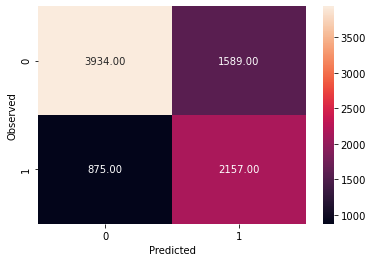

None
              precision    recall  f1-score   support

           1       0.82      0.71      0.76      5523
           2       0.58      0.71      0.64      3032

    accuracy                           0.71      8555
   macro avg       0.70      0.71      0.70      8555
weighted avg       0.73      0.71      0.72      8555



In [25]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression

## function to get confusion matrix in a proper format
def draw_cm( actual, predicted ):
    cm = confusion_matrix( actual, predicted)
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels = [0,1] , yticklabels = [0,1] )
    plt.ylabel('Observed')
    plt.xlabel('Predicted')
    plt.show()

print("Training accuracy",round(modelFINAL.score(X_train_scaled_cls,y_train_cls),ndigits=3))
print()
print("Testing accuracy",round(mt.accuracy_score(y_test_cls, y_hat),ndigits=3))
print()
print('Confusion Matrix')
print(draw_cm(y_test_cls,y_hat))

print(classification_report(y_test_cls,y_hat))

In [27]:
#coefficient output based on in-class example
weights = modelFINAL.coef_.T
x = pd.DataFrame(pdata_cls)
variable_names = x.columns
for coef,name in zip(weights, variable_names):
    print(name, 'has weight of', round(coef[0],ndigits=2))

log_price has weight of -0.1
property_type has weight of 0.1
accommodates has weight of 0.31
bathrooms has weight of -0.04
host_identity_verified has weight of -0.01
instant_bookable has weight of 0.08
number_of_reviews has weight of 0.12
review_scores_rating has weight of 0.22
bedrooms has weight of 0.12
beds has weight of 0.42
room_type_Private room has weight of 0.06
room_type_Shared room has weight of -0.02
bed_type_Couch has weight of 0.01
bed_type_Futon has weight of 0.01
bed_type_Pull-out Sofa has weight of 0.02
bed_type_Real Bed has weight of -0.03
city_Chicago has weight of 0.16
city_DC has weight of 0.22
city_LA has weight of -0.35
city_NYC has weight of 0.07
city_SF has weight of 0.0
cancellation_policy_moderate has weight of -0.04
cancellation_policy_strict has weight of -0.03
cancellation_policy_super_strict_30 has weight of 0.04
cancellation_policy_super_strict_60 has weight of -0.24


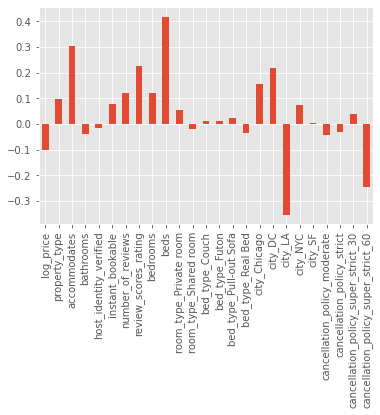

In [28]:
#coeffient plot from class example

from matplotlib import pyplot as pyplot
%matplotlib inline
variable_names = list(pdata_cls)[0:-1]
plt.style.use('ggplot')

weights = pd.Series(modelFINAL.coef_[0],index=variable_names)
weights.plot(kind='bar')
plt.show()

##### 2.2.2 Regression Task

In [29]:
# create cross validation iterator
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=10, test_size = 0.2, train_size = 0.8, random_state=42)

# now iterate through and get predictions, saved to the correct row in yhat
# NOTE: you can parallelize this using the cross_val_predict method
# fill in the training and testing data and save as separate variables
for trainidx, testidx in cv.split(X_scaled_reg,y_reg):
    # note that these are sparse matrices
    X_train_scaled_reg = X_scaled_reg[trainidx]
    X_test_scaled_reg = X_scaled_reg[testidx]
    y_train_reg = y_reg[trainidx]
    y_test_reg = y_reg[testidx]

In [30]:
#verifying the test vs train split
print("{0:0.2f}% data is in training set".format((len(X_train_scaled_reg)/len(pdata_reg.index)) * 100))
print("{0:0.2f}% data is in test set".format((len(X_test_scaled_reg)/len(pdata_reg.index)) * 100))

80.00% data is in training set
20.00% data is in test set
